In [1]:
%matplotlib inline
import _init_paths

from model.config import cfg
from model.test import im_detect
from model.nms_wrapper import nms

from utils.timer import Timer
import matplotlib.pyplot as plt
import numpy as np
import os, cv2
import argparse

from nets.vgg16 import vgg16
from nets.resnet_v1 import resnetv1

import torch

CLASSES = ('__background__',
           'chinese', 'english', 'number')

NETS = {'vgg16': ('vgg16_faster_rcnn_iter_%d.pth',),'res101': ('res101_faster_rcnn_iter_%d.pth',)}
DATASETS= {'pascal_voc': ('voc_2007_trainval',),'pascal_voc_0712': ('voc_2007_trainval+voc_2012_trainval',)}


In [12]:
def vis_detections(im, class_name, dets, thresh=0.5):
    """Draw detected bounding boxes."""
    inds = np.where(dets[:, -1] >= thresh)[0]
    if len(inds) == 0:
        return

    im = im[:, :, (2, 1, 0)]
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.imshow(im, aspect='equal')
    for i in inds:
        bbox = dets[i, :4]
        score = dets[i, -1]

        ax.add_patch(
            plt.Rectangle((bbox[0], bbox[1]),
                          bbox[2] - bbox[0],
                          bbox[3] - bbox[1], fill=False,
                          edgecolor='red', linewidth=3.5)
            )
        ax.text(bbox[0], bbox[1] - 2,
                '{:s} {:.3f}'.format(class_name, score),
                bbox=dict(facecolor='blue', alpha=0.5),
                fontsize=14, color='white')

    ax.set_title(('{} detections with '
                  'p({} | box) >= {:.1f}').format(class_name, class_name,
                                                  thresh),
                  fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.draw()
    plt.show()

In [15]:
def demo(image_name):
    """Detect object classes in an image using pre-computed object proposals."""

    net = resnetv1(num_layers=101)
    net.create_architecture(4, tag='default', anchor_scales=[8, 16, 32])

    net.load_state_dict(torch.load(os.path.join('../output', 'res101', 'NameCardtrainvalNameCardReal', 'default',
                              'res101_faster_rcnn_iter_200000.pth'), map_location=lambda storage, loc: storage))
    net.eval()
    if not torch.cuda.is_available():
        net._device = 'cpu'
    net.to(net._device)
    # Load the demo image
    im_file = os.path.join(image_name)
    im = cv2.imread(im_file)
    # Detect all object classes and regress object bounds
    timer = Timer()
    timer.tic()
    scores, boxes = im_detect(net, im)
    timer.toc()
    print('Detection took {:.3f}s for {:d} object proposals'.format(timer.total_time(), boxes.shape[0]))

    # Visualize detections for each class
    CONF_THRESH = 0.8
    NMS_THRESH = 0.3
    for cls_ind, cls in enumerate(CLASSES[1:]):
        cls_ind += 1 # because we skipped background
        cls_boxes = boxes[:, 4*cls_ind:4*(cls_ind + 1)]
        cls_scores = scores[:, cls_ind]
        dets = np.hstack((cls_boxes,
                          cls_scores[:, np.newaxis])).astype(np.float32)
        keep = nms(torch.from_numpy(dets), NMS_THRESH)
        dets = dets[keep.numpy(), :]
        vis_detections(im, cls, dets, thresh=CONF_THRESH)

Detection took 0.160s for 300 object proposals


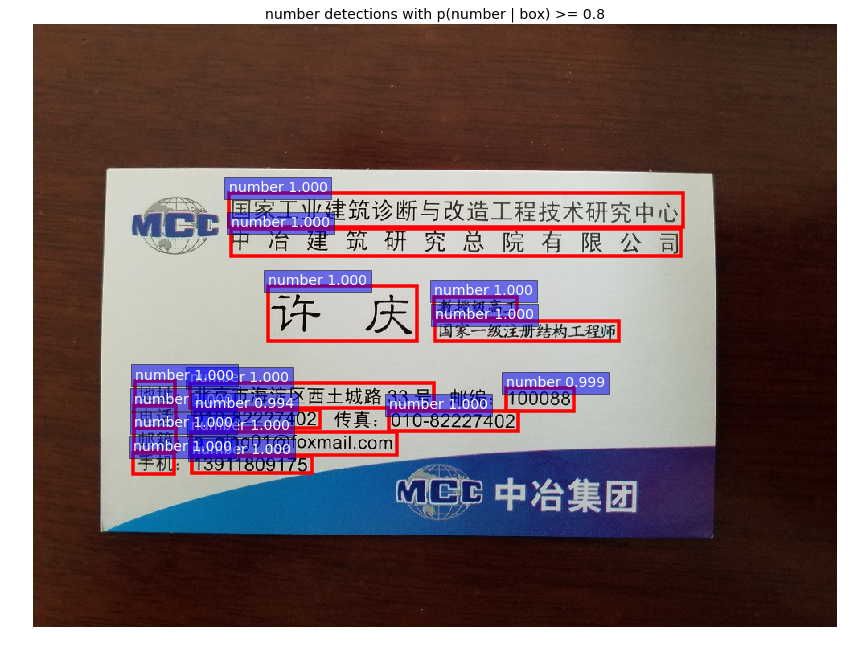

In [16]:
demo('../data/NameCard/NameCardReal/JPEGImages/1482.jpg')